# **Introduction**

The proliferation of user-generated content on online platforms has created a pressing need for effective moderation tools to combat harmful and toxic behavior. Toxic comments, which can include offensive language, threats, insults, and hate speech, not only degrade the quality of online discourse but also pose significant risks to individuals and communities. To address this challenge, this project focuses on developing a deep learning model capable of automatically detecting and categorizing toxic comments into multiple labels, such as 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', and 'identity_hate'.

By leveraging a multi-label classification approach, the project aims to accurately identify and classify comments that fall into one or more of these toxic categories. This capability is essential for online platforms seeking to maintain a safe and welcoming environment, as it allows for the automated flagging and potential removal of harmful content. Through this project, we aim to demonstrate the effectiveness of machine learning techniques in addressing the complexities of content moderation, contributing to the broader effort of promoting positive online interactions.

The dataset is taken from from: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

In [3]:
# Load the training dataset
train = pd.read_csv('/content/drive/MyDrive/5011 Final/train.csv')
print("Training set shape: ", train.shape)
train.head()


Training set shape:  (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Load the testing dataset

test = pd.read_csv('/content/drive/MyDrive/5011 Final/test.csv')
print("Test set shape: ", test.shape)
test.head()

Test set shape:  (153164, 2)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# **Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data**

In [5]:
# Check for missing values
print("Training missing data: \n", train.isnull().sum())
print("Testig missing data: \n", test.isnull().sum())

# Drop rows with missing 'comment_text' in training data, if any.
train = train.dropna(subset=['comment_text'])

# Define target columns
target_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Explore the comment lengths in training data (optional)
train['comment_length'] = train['comment_text'].apply(len)
print("Training set comment length distribution: \n", train['comment_length'].describe())



Training missing data: 
 id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Testig missing data: 
 id              0
comment_text    0
dtype: int64
Training set comment length distribution: 
 count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64


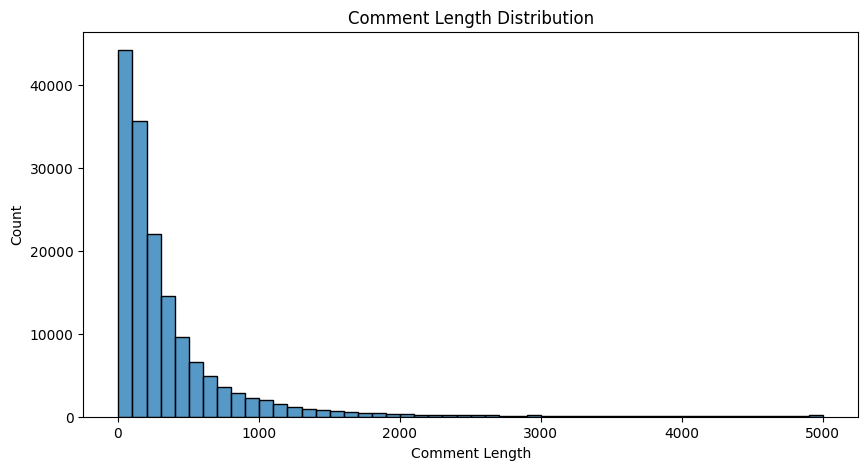

In [6]:

# Plot the distribution of comment lengths (optional)
plt.figure(figsize=(10,5))
sns.histplot(data=train, x="comment_length", bins=50)
plt.title("Comment Length Distribution")
plt.xlabel("Comment Length")
plt.show()

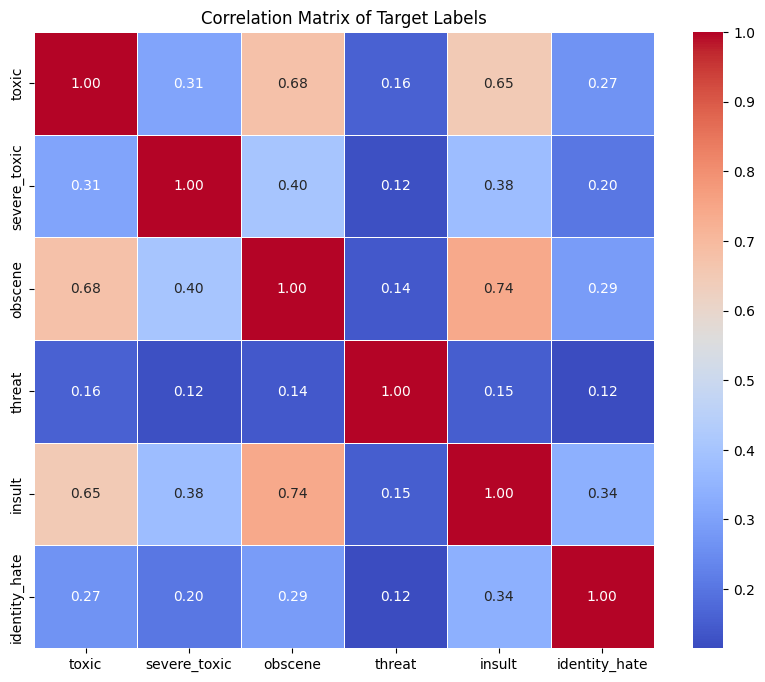

In [7]:
# Compute correlation matrix
correlation_matrix = train[target_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Target Labels')
plt.show()


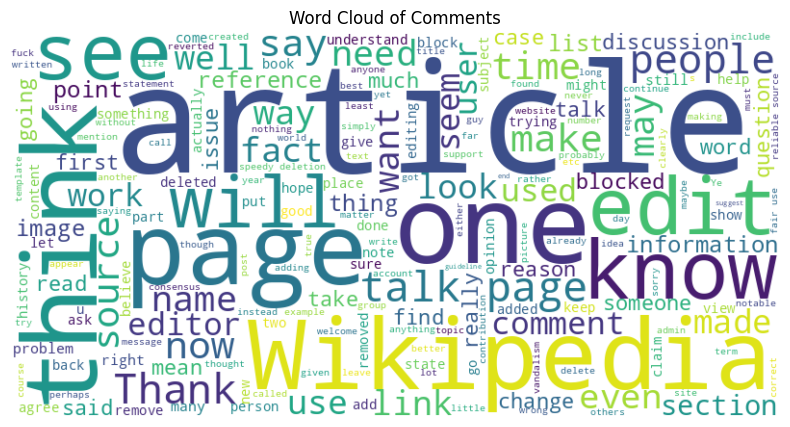

In [8]:
from wordcloud import WordCloud

# Combine all comments into a single string
text = ' '.join(comment for comment in train['comment_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()


# **Text Tokenization and Padding**

In [9]:
# Define hyperparameters
max_features = 20000  # Maximum number of words to consider as features
maxlen = 200          # Maximum length of each comment
embed_size = 128      # Embedding vector size

In [10]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['comment_text'])
list_tokenized_train = tokenizer.texts_to_sequences(train['comment_text'])
list_tokenized_test = tokenizer.texts_to_sequences(test['comment_text'])

# Pad the sequences to ensure uniform input size
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

# Define target variables
y_train = train[target_columns].values

# **Model Building and Training**

In [11]:
# Define the model architecture
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(60, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(len(target_columns), activation='sigmoid')(x)  # Multi-label classification

# Compile the model
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('multi_label_toxic_comment_model.keras', save_best_only=True, verbose=1)


In [12]:
# Train and save the model for reuse.
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1,
                    callbacks=[early_stopping, model_checkpoint])

model.save('/content/drive/MyDrive/5011 Final/multi_label_toxic_comment_model_final.keras')



Epoch 1/10
4487/4488 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9076 - loss: 0.0997
Epoch 1: val_loss improved from inf to 0.04906, saving model to multi_label_toxic_comment_model.keras
4488/4488 ━━━━━━━━━━━━━━━━━━━━ 64s 13ms/step - accuracy: 0.9076 - loss: 0.0997 - val_accuracy: 0.9940 - val_loss: 0.0491
Epoch 2/10
4485/4488 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9878 - loss: 0.0458
Epoch 2: val_loss improved from 0.04906 to 0.04723, saving model to multi_label_toxic_comment_model.keras
4488/4488 ━━━━━━━━━━━━━━━━━━━━ 77s 13ms/step - accuracy: 0.9878 - loss: 0.0458 - val_accuracy: 0.9939 - val_loss: 0.0472
Epoch 3/10
4487/4488 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9802 - loss: 0.0396
Epoch 3: val_loss did not improve from 0.04723
4488/4488 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - accuracy: 0.9802 - loss: 0.0396 - val_accuracy: 0.9930 - val_loss: 0.0473
Epoch 4/10
4485/4488 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9491 - loss: 0.0342
Epoch 4: val_loss did not 

# **Model Evaluation and Prediction on the Test Set**

In [13]:
# Load the best model
model.load_weights('/content/drive/MyDrive/5011 Final/multi_label_toxic_comment_model_final.keras')

# Make predictions on the test set
y_test_pred = model.predict(X_test, batch_size=1024)
y_test_pred = (y_test_pred > 0.5).astype(int)

# Save predictions to a CSV file
pred_df = pd.DataFrame(y_test_pred, columns=target_columns)
pred_df.insert(0, 'id', test['id'])
pred_df.to_csv('/content/drive/MyDrive/5011 Final/test_predictions.csv', index=False)

print("Predictions saved successfully.")


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Predictions saved successfully.


In [14]:

pred_df = pd.read_csv('/content/drive/MyDrive/5011 Final/test_predictions.csv')

# Summarize the count of comments in each category
category_counts = pred_df[target_columns].sum().sort_values(ascending=False)

# Print the summary
print("Category Counts:\n", category_counts)


Category Counts:
 toxic            31138
obscene          18544
insult           13376
identity_hate     1411
severe_toxic       925
threat               0
dtype: int64


<ipython-input-15-0523e5343cfc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


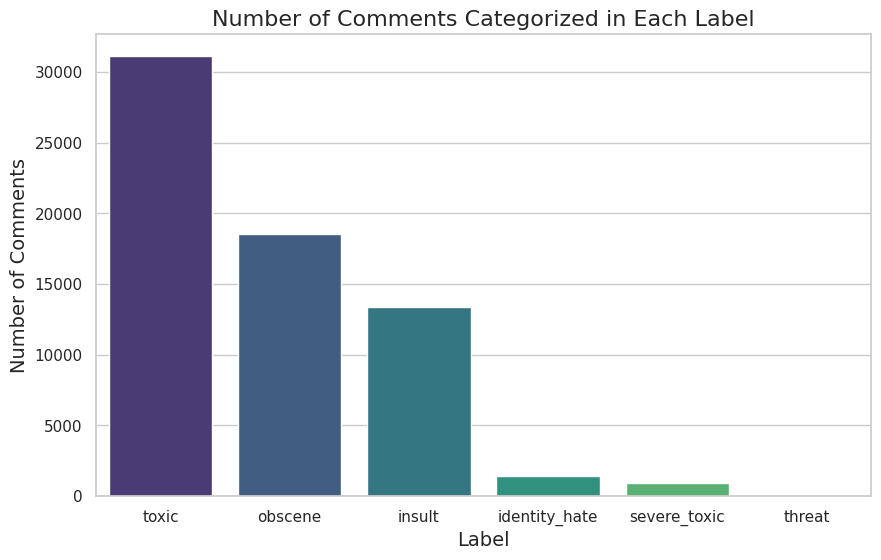

In [15]:
# Set the plot style
sns.set(style="whitegrid")

# Create a bar plot for category counts
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")

# Add title and labels
plt.title("Number of Comments Categorized in Each Label", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Number of Comments", fontsize=14)

# Show the plot
plt.show()


In [16]:
import pandas as pd

# Load the predictions and test data
pred_df = pd.read_csv('/content/drive/MyDrive/5011 Final/test_predictions.csv')
test_df = pd.read_csv('/content/drive/MyDrive/5011 Final/test.csv')

# Ensure the test dataframe contains the 'id' and 'comment_text' columns
print(test_df.columns)


Index(['id', 'comment_text'], dtype='object')


In [17]:
# Merge predictions with the test data based on the 'id' column
merged_df = pd.merge(test_df[['id', 'comment_text']], pred_df, on='id')

# Display the first few rows of the merged dataframe
print(merged_df.head())


                 id                                       comment_text  toxic  \
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...      1   
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...      0   
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...      0   
3  00017563c3f7919a  :If you have a look back at the source, the in...      0   
4  00017695ad8997eb          I don't anonymously edit articles at all.      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        1       0       1              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [20]:
# Define a function to extract samples for each category
def sample_comments_for_label(label, n_samples=5):
    # Filter the merged dataframe where the label is predicted as 1
    sample_df = merged_df[merged_df[label] == 1]

    # Check if there are any samples available
    if sample_df.empty:
        print(f"No comments were predicted as '{label}'.")
        return pd.DataFrame(columns=['id', 'comment_text', label])

    # Take a random sample of size n_samples
    sample_comments = sample_df.sample(n=n_samples, random_state=42)

    return sample_comments[['id', 'comment_text', label]]

sample=5
# Sample comments for each label
toxic_samples = sample_comments_for_label('toxic', n_samples=sample)
severe_toxic_samples = sample_comments_for_label('severe_toxic', n_samples=sample)
obscene_samples = sample_comments_for_label('obscene', n_samples=sample)
threat_samples = sample_comments_for_label('threat', n_samples=sample)
insult_samples = sample_comments_for_label('insult', n_samples=sample)
identity_hate_samples = sample_comments_for_label('identity_hate', n_samples=sample)


No comments were predicted as 'threat'.


In [21]:
from IPython.core.display import display, HTML

def display_as_html(label, samples):
    if samples.empty:
        print(f"No comments were predicted as '{label}'.\n")
    else:
        print(f"Sample comments for '{label}' label:\n")
        display(HTML(samples.to_html()))

# Display each label's samples as an HTML table
display_as_html('toxic', toxic_samples)
display_as_html('severe_toxic', severe_toxic_samples)
display_as_html('obscene', obscene_samples)
display_as_html('threat', threat_samples)
display_as_html('insult', insult_samples)
display_as_html('identity_hate', identity_hate_samples)


Sample comments for 'toxic' label:



,id,comment_text,toxic
125553,d1b81206a6cac7ab,==Dotonj is a sock puppet of banned chauvinist user:Iaaasi== \n\n Dotonj is a sock pppet of banned chauvinist user:Iaaasi,1
119387,c758a6d1305beb16,BAMF stands for Bad Ass Mother Fucker put that,1
82356,895fdf7c09158c49,FUCKING PUSSY IS ASOME,1
26692,2c66b6c902a599b2,==A humble suggestion== \n Have you tried autofellatio? I hear it makes you less of a fucking asshole. Go suck yourself.,1
42067,45c402e7c2b59a90,"LOL== \n\n Are you all f... up ??? \n Do you read all of this? Go get some girls guys, and get some life! \n Macedonia was, is, and will be Macedonia. \n\n ==",1


Sample comments for 'severe_toxic' label:



Sample comments for 'obscene' label:



,id,comment_text,obscene
19425,20982d9d127fe418,"""After the block, You explicitly 47 times edited (continued disruption) using anonymous accounts. Then You re-make an account, but continue doing bad things, like (""""sucking Vojislav Seselj's dick""""), not to mention the numerous other personal attacks. \n\n You're not banned from Wikipedia for a beginner's mistake, but for repeatedly violated the very same rules and doing the very same things after being for exactly 23 times. Just like a certain administrator said about You sir, A donkey would've learned by then. \n\n If You have a case around Giovanni Giove (so far I've only seen POV-sided incivility, including mild personal attacks against myself), please show it. Show me his sock-puppets. Give me the links to severe Wikipedia violations. If the reasons are substantiated enough (i.e. he earned a block), his account will be prevented from editing. \n\n :Just for the record - I'm not doing this because of anyone (I do not collaborate with trolls), but solely because of Wikipedia's policy. """,1
117783,c499602b4452b713,""" \n\n ::His point is that he's a Nazi fuck (or whatever shorthand you want to use for Holocaust deniers; all he had to do was use the term """"holohoax"""" once to make it clear for all to see what he is.) """,1
51803,55f75e2a0f5dbf6d,"Are you kidding me????? She wasn't angry because fame didn't enter her life, she was angry because you people in Wikipedia were putting wrong information about her on this page, and when she fixed it all up, you just changed it all back to the bullshit that was on it before, and said that who ever edited it didn't know anything and got it all wrong!! I think she would know her own bloody life don't you?? Wikipedia is stupid and where the hell do you get all the information, because clearly you were completely wrong, and the whole reason why she asked us Plague Rats to fuck up her Wikipedia page was just to see how much bullshit can be put onto a page, by the public. Which apparently was a lot!!",1
133617,df5d0e303d73720c,== Go Suck Jimmy Wales Dick == \n\n you are a curry munching stinking f*ck.,1
93068,9b3ba105e2f46fa6,==O== \n Super Mario 64 has FUCKING BAD GRAPHICS,1


No comments were predicted as 'threat'.

Sample comments for 'insult' label:



,id,comment_text,insult
82294,894d2c447d65a054,== fuck smosh == \n fuck smosh,1
12816,158ab22a5e1bf305,""" \n :Try this: Put your finger in your mouth and suck on it. While sucking, breathe in and out through your nose. If the sucking was via your lungs, this should be impossible. It isn't. Q.E.D. - """,1
108683,b5566e348745a5e0,get your facts right idiot I have heard this from a Emirates member,1
6998,0bcdbba5fa623451,of myself being ass ravaged,1
77843,81da31843bd40d7c,PETA is just a bunch of stupid smelly dumbasses that believe that they are just like animals(which is the gayest thing ever) but most animals are carnivors so their arguemenr is s***!,1


Sample comments for 'identity_hate' label:



,id,comment_text,identity_hate
35834,3b919bae5257c196,I WILL KILL YOU BASTARD,1
94309,9d4f14a86ae744de,"== You win == \n\n I hate to admit it, you little fascist/ communist/ racist/ anti-semite/ biased person/ revisionist/ philo-Semite/ Semite/ anti-Semite/ trouble user/ uncivilised barbarian/ nationalist/ placename fetishist/ German revisionist / Polish pan/ Ukrainian nationalist / Polish Nazi/ Slavic monkey/ native of Lower Dneper/ stupid slave/ Polish fascist/ chauvinist/ falsificator (sic!)/ slave / dumb Polak / Jew / Slav / Sclavonian /ape-man / salamander/ fish, but you have a point. I changed my vote at Talk:Wojsko Polskie. 4 July 2005 21:50 (UTC)",1
143719,f0351eaa5101256e,I hope your die bitch.,1
19038,1ffc668b2701fed1,fuck all the admins of this gay site.,1
85535,8eb183a2c41e8902,==Faggots== \n Wikipedia is full of faggots.,1


**Summary**


In this project, we developed a multi-label classification model to identify toxic comments across various categories, including 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', and 'identity_hate'. We began by loading and pre-processing the dataset, which involved checking for missing values, dropping incomplete records, and exploring the distribution of comment lengths.

Our model was trained and validated, and we used various metrics, including the classification report, to evaluate its performance across different labels. After fine-tuning the model and loading the best-performing version, we made predictions on the test set.

To ensure the model's reliability, we extracted and displayed sample comments predicted as belonging to each toxic category, facilitating manual verification. Despite the model's overall effectiveness, it was noted that no comments were predicted under the 'threat' category, highlighting an area that may require further investigation or additional data.

**Conclusion**



This multi-label classification model demonstrates the capability to effectively categorize toxic comments across multiple dimensions, which can be particularly useful in moderating online platforms and ensuring safer online environments. The process highlighted the importance of careful data preprocessing, model selection, and evaluation to achieve robust performance.

Future work could focus on improving the model's ability to detect less frequent categories, such as 'threat', by enhancing the dataset with more diverse examples or exploring different model architectures. Additionally, implementing more sophisticated techniques for data augmentation and model interpretability could further refine the model's accuracy and reliability in real-world applications.